Make sure to set the runtime to GPU: Runtime -> Change runtime type -> T4 GPU

You can upload your own images, then change the relevant code cells to load it and send it through the model.

In [ ]:
# install the intrinsic decomposition repo from github
# !pip install https://github.com/compphoto/Intrinsic/archive/main.zip

In [1]:
import torch

# import some helper functions from chrislib (will be installed by the intrinsic repo)
from chrislib.general import show, view, invert
from chrislib.data_util import load_from_url, load_image

# import model loading and running the pipeline
from intrinsic.pipeline import load_models, run_residual_pipeline_gpu, run_pipeline

In [2]:
# download the pretrained weights and return the model (may take a bit to download weights the first time)
intrinsic_model = load_models('v2')

loading v2 weights


Using cache found in /home/slanley/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /home/slanley/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/slanley/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /home/slanley/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /home/slanley/.cache/torch/hub/facebookresearch_WSL-Images_main


### CPU

In [13]:

img_np = load_image('examples/synthetic_nerf/drums.png')

sizes: (800, 800, 3) (800, 800, 3)


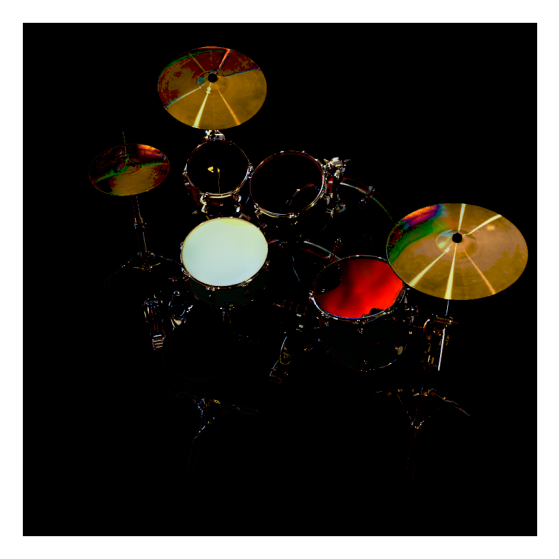

In [14]:

result = run_pipeline(intrinsic_model, img_np, stage=4, device='cuda', specular_threshold=0.2, inputs='all', maintain_size=False)

print("sizes:", img_np.shape, result['residual'].shape)
res = result['residual']
neg_res = result['neg_res']
pos_res = result['pos_res']

comb_res = (neg_res + pos_res).clip(0,1)
# show([img_np, neg_res, pos_res, neg_res + pos_res], size=(30,7))
show([comb_res], size=(30,7))

## GPU

In [3]:
# img_np = load_image('examples/synthetic_nerf/drums.png')
img_np = load_image('examples/mipnerf/bench.JPG')

img_t = torch.from_numpy(img_np).to('cuda')
if img_t.dtype != torch.float32:
    img_t = img_t.float()
    
print('input image shape:', img_t.shape, 'dtype:', img_t.dtype)

input image shape: torch.Size([822, 1237, 3]) dtype: torch.float32


sizes: (822, 1237, 3) (832, 1248, 3)


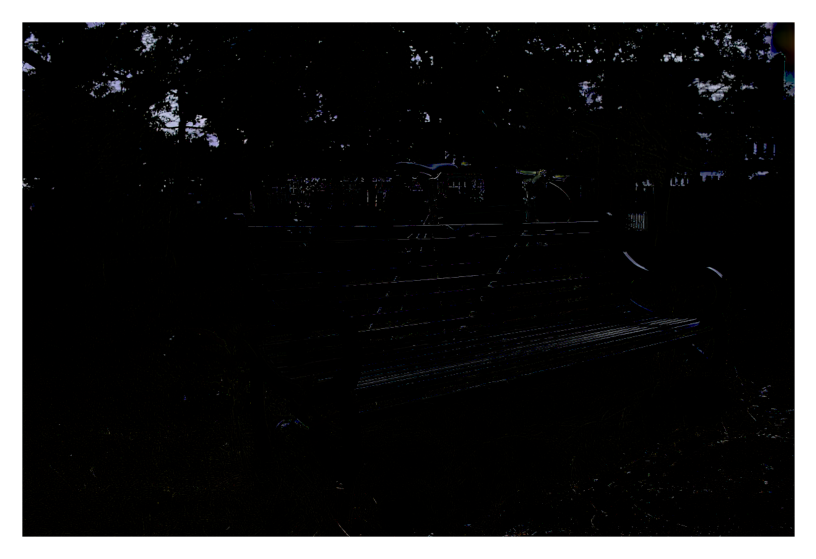

In [6]:
# run fully on GPU
result = run_residual_pipeline_gpu(
    intrinsic_model,
    torch.clamp(img_t, 0.0, 1.0),
    # img_t,
    device='cuda',
    specular_threshold=0.2,
    inputs='all' #can be all, rgb or base
)

# print(result['residual'].device)
# # # # For visualization ONLY (convert selected tensors back to cpu numpy)
def to_np(t):
    return t.detach().cpu().clamp(0, 1).numpy()
print("sizes:", img_np.shape, to_np(result['residual']).shape)
res = to_np(result['residual'])
neg_res = to_np(result['neg_res'])
pos_res = to_np(result['pos_res'])
comb_res = to_np((result['neg_res'] + result['pos_res']).clip(0,1))

show([comb_res], size=(30,7))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49022793769836426..1.0].


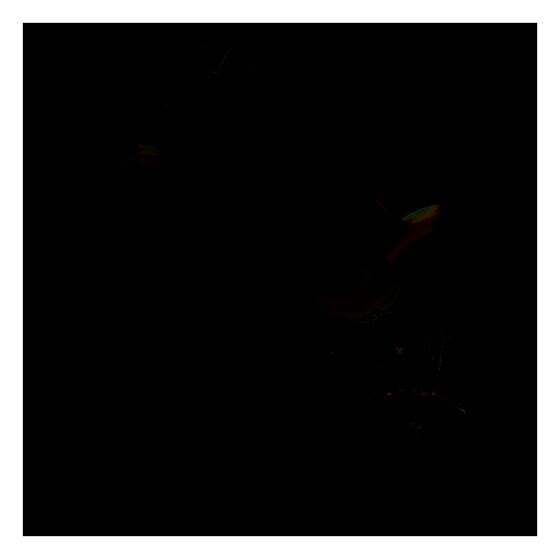

In [9]:
# run fully on GPU
result = run_residual_pipeline_gpu(
    intrinsic_model,
    torch.clamp(img_t, 0.0, 1.0),
    # img_t,
    device='cuda',
    specular_threshold=0.2,
    inputs='all' #can be all, rgb or base
)
result_2 = run_residual_pipeline_gpu(
    intrinsic_model,
    torch.clamp(img_t, 0.0, 1.0),
    # img_t,
    device='cuda',
    specular_threshold=0.2,
    inputs='other' #can be all, rgb or base
)

# print(result['residual'].device)
# # # # For visualization ONLY (convert selected tensors back to cpu numpy)
def to_np(t):
    return t.detach().cpu().clamp(0, 1).numpy()

res = to_np(result['residual'])
neg_res = to_np(result['neg_res'])
pos_res = to_np(result['pos_res'])
comb_res = to_np((result['neg_res'] + result['pos_res']).clip(0,1))

comb_res2 = to_np((result_2['neg_res'] + result_2['pos_res']).clip(0,1))

show([comb_res - comb_res2], size=(30,7))